# Data Preprocessing
We need to filter and feature-select data to provide consistent inputs to dimensionality reduction methods.

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [185]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

---
To benchmark dimensionality reduction techniques, we are using two datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be highly __discrete__, containing highly separable cell populations, where the latter should be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
In this notebook, we will read in the counts for each of these datasets, _select gene features_ to limit input size to dimensionality reduction methods, and _downsample to a common cell number_ for ease of comparison.

---
#### 0.0 read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [2]:
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [3]:
# see how many cells and genes are present in whole counts matrix
retina.data.shape

(6600, 20478)

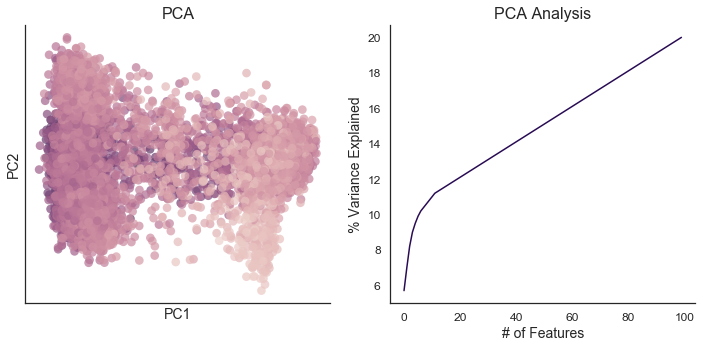

In [87]:
# arcsinh-normalize fractional counts for all 20k+ genes, and perform 100 component PCA
retina_PCA100 = fcc_PCA(retina.arcsinh_norm(norm='l1'), n_components=100)
retina_PCA100.plot_PCA()

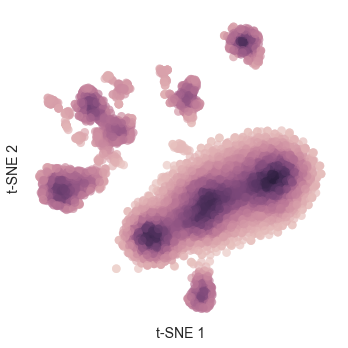

CPU times: user 1min 1s, sys: 1.07 s, total: 1min 2s
Wall time: 1min 2s


In [189]:
%%time 
# now perform standard t-SNE (perplexity 30) and show results
retina_tSNE = fcc_tSNE(retina_PCA100.results, perplexity=30, seed=18)
retina_tSNE.plot()

---
#### 0.1 assign clusters
* density-peak clustering of whole-dataset t-SNE

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131cbb6d8>)

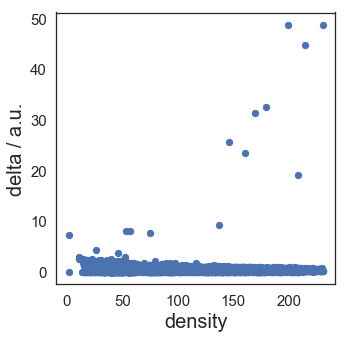

In [190]:
# show potential density-peak cluster centers
retina_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x138ee5080>)

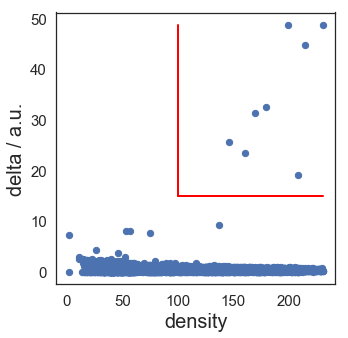

In [191]:
# assign cluster center cutoffs and show decision graph again
retina_tSNE.clu.assign(100,15)
retina_tSNE.clu.draw_decision_graph(min_delta=retina_tSNE.clu.min_delta, 
                                    min_density=retina_tSNE.clu.min_density)

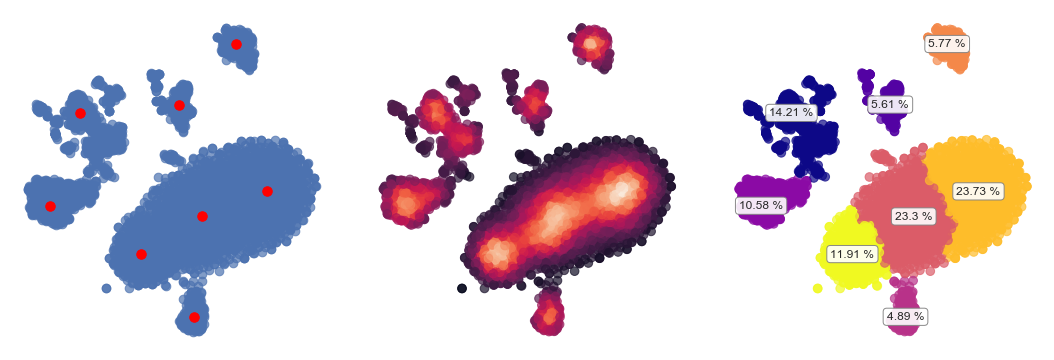

In [192]:
retina_tSNE.plot_clusters() # visualize clustering

In [193]:
retina_tSNE.cluster_counts()

938 cells in cluster 0 (14.212 %)

370 cells in cluster 1 (5.606 %)

698 cells in cluster 2 (10.576 %)

323 cells in cluster 3 (4.894 %)

1538 cells in cluster 4 (23.303 %)

381 cells in cluster 5 (5.773 %)

1566 cells in cluster 6 (23.727 %)

786 cells in cluster 7 (11.909 %)



In [194]:
print('Silhouette Score: {}\n'.format(retina_tSNE.silhouette_score()))

Silhouette Score: 0.52654629945755



---
#### 0.2 filter genes and cells to manageable size
* _select variable genes_ to reduce dimension
* _downsample cells_ for future processing, maintaining cluster proportions

In [11]:
# select 500 most variable genes
retina_varselect = RNA_counts.var_select(retina, n_features=500) 

In [14]:
# choose 1600 cells with proportional representation from clusters above
retina_0 = RNA_counts.downsample_proportional(retina_varselect, retina_tSNE.clu.membership, n_cells=1600, seed=18)

In [15]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(retina_0.data.sum(axis=1).min(), retina_0.data.sum(axis=0).min()))

minimum counts per cell: 132
minimum counts per gene: 3


Now, we can re-visualize as before to make sure we have a representative subset of the data:

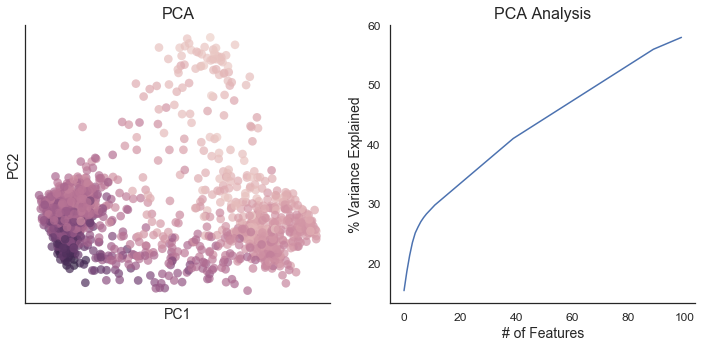

CPU times: user 1.25 s, sys: 126 ms, total: 1.38 s
Wall time: 1e+03 ms


In [184]:
%%time
retina_0_PCA100 = fcc_PCA(matrix=retina_0.arcsinh_norm(), n_components=100)
retina_0_PCA100.plot_PCA()

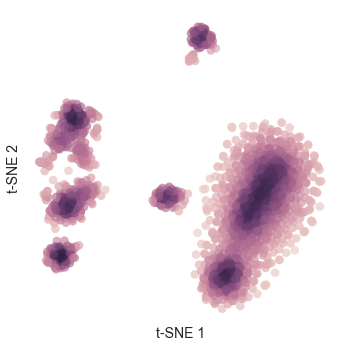

CPU times: user 10.2 s, sys: 140 ms, total: 10.4 s
Wall time: 10.4 s


In [186]:
%%time
retina_0_tSNE = fcc_tSNE(retina_0_PCA100.results, perplexity=30, seed=18)
retina_0_tSNE.plot()

Print out some cell type markers for cluster identification:

In [195]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='retina_Opn1mw.png', figsize=(10,10))

In [196]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='retina_Rlbp1.png', figsize=(10,10))

In [197]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='retina_Vsx2.png', figsize=(10,10))

In [198]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='retina_Pax6.png', figsize=(10,10))

---
#### 0.3 write results to file

In [19]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.tsv', sep='\t', header=True, index=True)

In [21]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.norowlabels.tsv', sep='\t', header=True, index=False)

---
#### 1.0 read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [3]:
colon = RNA_counts.from_file(datafile='../inputs/GSM2743164_rep1_colon_rnaseq.csv.gz', cells_axis=1, labels=[0,0])

In [4]:
# see how many cells and genes are present in whole counts matrix
colon.data.shape

(1738, 25504)

This cell number is already what we want.  Let's just select the 500 most variable genes and visualize the dataset.

---
#### 1.1 filter genes to manageable size
* _select variable genes_ to reduce dimension

In [5]:
# select 500 most variable genes
colon_0 = RNA_counts.var_select(colon, n_features=500) 

In [6]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(colon_0.data.sum(axis=1).min(), colon_0.data.sum(axis=0).min()))

minimum counts per cell: 307
minimum counts per gene: 249


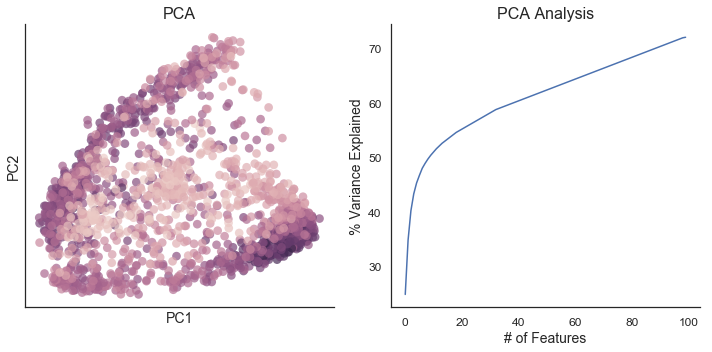

CPU times: user 1.25 s, sys: 118 ms, total: 1.37 s
Wall time: 869 ms


In [7]:
%%time
colon_0_PCA100 = fcc_PCA(matrix=colon_0.arcsinh_norm(), n_components=100)
colon_0_PCA100.plot_PCA()

In [10]:
%%time
colon_0_tSNE = fcc_tSNE(colon_0_PCA100.results, perplexity=30, seed=11)

CPU times: user 10 s, sys: 110 ms, total: 10.1 s
Wall time: 10.2 s


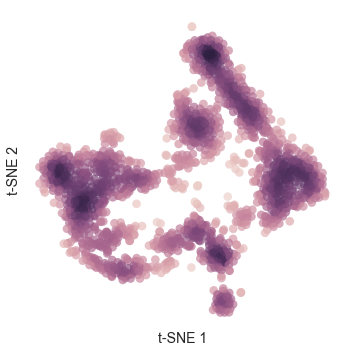

In [11]:
colon_0_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128257cf8>)

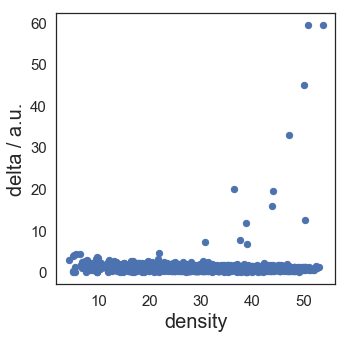

In [12]:
# show potential density-peak cluster centers
colon_0_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129479eb8>)

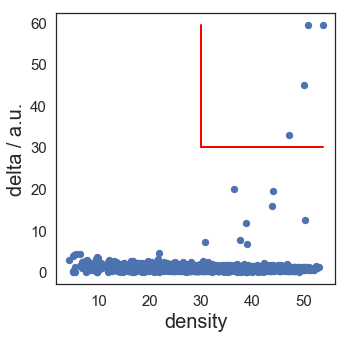

In [23]:
# assign cluster center cutoffs and show decision graph again
colon_0_tSNE.clu.assign(30,30)
colon_0_tSNE.clu.draw_decision_graph(min_delta=colon_0_tSNE.clu.min_delta, 
                                    min_density=colon_0_tSNE.clu.min_density)

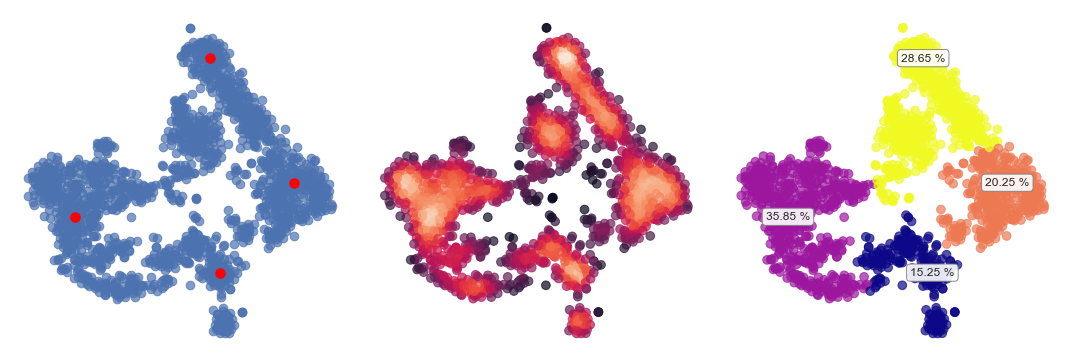

In [24]:
colon_0_tSNE.plot_clusters() # visualize clustering

Print out some cell type markers for cluster identification:

In [25]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt8'].flatten(), save_to='colon_Krt8.png', figsize=(6,6))

In [29]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Cd8a'].flatten(), save_to='colon_Cd8a.png', figsize=(6,6))

In [26]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='colon_Muc2.png', figsize=(6,6))

In [27]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='colon_Krt20.png', figsize=(6,6))

In [28]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='colon_Reg4.png', figsize=(6,6))

---
#### 1.2 write results to file

In [24]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', sep='\t', header=True, index=True)

In [25]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv', sep='\t', header=True, index=False)